## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 192
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["3", "1"]
TEST_FRAGMENT = "2"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

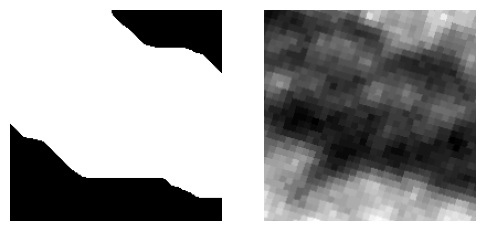

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-192 if x1 != 0 else 0, 192)
        y_offset = random.randint(-192 if y1 != 0 else 0, 192)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [13]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [14]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [15]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [17]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [18]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    # if epoch >= 10:
    #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 7.21GB  LR : 4.00E-06  Loss: 0.7005: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]                                                                                                                                                                         
Val Loss: 0.5973: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.155611
Threshold : 0.25	FBeta : 0.173697
Threshold : 0.30	FBeta : 0.206933
Threshold : 0.35	FBeta : 0.231565
Threshold : 0.40	FBeta : 0.243342
Threshold : 0.45	FBeta : 0.226486
Threshold : 0.50	FBeta : 0.153302
Threshold : 0.55	FBeta : 0.053802
Threshold : 0.60	FBeta : 0.010942
Threshold : 0.65	FBeta : 0.001248
Threshold : 0.70	FBeta : 0.000006
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 11.7GB  LR : 1.81E-05  Loss: 0.6612: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                         
Val Loss: 0.6308: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.158176
Threshold : 0.25	FBeta : 0.166386
Threshold : 0.30	FBeta : 0.177275
Threshold : 0.35	FBeta : 0.186517
Threshold : 0.40	FBeta : 0.193708
Threshold : 0.45	FBeta : 0.193924
Threshold : 0.50	FBeta : 0.182597
Threshold : 0.55	FBeta : 0.157357
Threshold : 0.60	FBeta : 0.120540
Threshold : 0.65	FBeta : 0.081720
Threshold : 0.70	FBeta : 0.051692
Threshold : 0.75	FBeta : 0.022644
Threshold : 0.80	FBeta : 0.004813



Epoch 3/50  Mem : 11.7GB  LR : 5.20E-05  Loss: 0.6206: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]                                                                                                                                                                         
Val Loss: 0.6110: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.177782
Threshold : 0.25	FBeta : 0.187320
Threshold : 0.30	FBeta : 0.190693
Threshold : 0.35	FBeta : 0.186623
Threshold : 0.40	FBeta : 0.172269
Threshold : 0.45	FBeta : 0.144020
Threshold : 0.50	FBeta : 0.082329
Threshold : 0.55	FBeta : 0.024490
Threshold : 0.60	FBeta : 0.010504
Threshold : 0.65	FBeta : 0.004536
Threshold : 0.70	FBeta : 0.000937
Threshold : 0.75	FBeta : 0.000102
Threshold : 0.80	FBeta : 0.000000



Epoch 4/50  Mem : 11.7GB  LR : 8.59E-05  Loss: 0.5956: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]                                                                                                                                                                         
Val Loss: 0.5617: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.225162
Threshold : 0.25	FBeta : 0.240660
Threshold : 0.30	FBeta : 0.253155
Threshold : 0.35	FBeta : 0.244876
Threshold : 0.40	FBeta : 0.219460
Threshold : 0.45	FBeta : 0.164002
Threshold : 0.50	FBeta : 0.089439
Threshold : 0.55	FBeta : 0.044653
Threshold : 0.60	FBeta : 0.022989
Threshold : 0.65	FBeta : 0.009529
Threshold : 0.70	FBeta : 0.004603
Threshold : 0.75	FBeta : 0.002514
Threshold : 0.80	FBeta : 0.001201



Epoch 5/50  Mem : 11.7GB  LR : 1.00E-04  Loss: 0.5797: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                         
Val Loss: 0.5518: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.238837
Threshold : 0.25	FBeta : 0.255099
Threshold : 0.30	FBeta : 0.267591
Threshold : 0.35	FBeta : 0.275526
Threshold : 0.40	FBeta : 0.283422
Threshold : 0.45	FBeta : 0.289597
Threshold : 0.50	FBeta : 0.287842
Threshold : 0.55	FBeta : 0.282760
Threshold : 0.60	FBeta : 0.274354
Threshold : 0.65	FBeta : 0.263134
Threshold : 0.70	FBeta : 0.245461
Threshold : 0.75	FBeta : 0.222560
Threshold : 0.80	FBeta : 0.192301



Epoch 6/50  Mem : 11.7GB  LR : 9.99E-05  Loss: 0.5417: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                         
Val Loss: 0.5445: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.274456
Threshold : 0.25	FBeta : 0.287669
Threshold : 0.30	FBeta : 0.289857
Threshold : 0.35	FBeta : 0.290855
Threshold : 0.40	FBeta : 0.290112
Threshold : 0.45	FBeta : 0.282757
Threshold : 0.50	FBeta : 0.270848
Threshold : 0.55	FBeta : 0.254541
Threshold : 0.60	FBeta : 0.227256
Threshold : 0.65	FBeta : 0.197125
Threshold : 0.70	FBeta : 0.165493
Threshold : 0.75	FBeta : 0.132688
Threshold : 0.80	FBeta : 0.098733



Epoch 7/50  Mem : 11.7GB  LR : 9.95E-05  Loss: 0.5207: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                         
Val Loss: 0.5608: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.226825
Threshold : 0.25	FBeta : 0.233436
Threshold : 0.30	FBeta : 0.236283
Threshold : 0.35	FBeta : 0.237987
Threshold : 0.40	FBeta : 0.238823
Threshold : 0.45	FBeta : 0.238883
Threshold : 0.50	FBeta : 0.238690
Threshold : 0.55	FBeta : 0.236579
Threshold : 0.60	FBeta : 0.231269
Threshold : 0.65	FBeta : 0.222032
Threshold : 0.70	FBeta : 0.208541
Threshold : 0.75	FBeta : 0.191722
Threshold : 0.80	FBeta : 0.170404



Epoch 8/50  Mem : 11.7GB  LR : 9.89E-05  Loss: 0.5017: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                         
Val Loss: 0.5383: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.304578
Threshold : 0.25	FBeta : 0.302866
Threshold : 0.30	FBeta : 0.297311
Threshold : 0.35	FBeta : 0.287204
Threshold : 0.40	FBeta : 0.272342
Threshold : 0.45	FBeta : 0.250001
Threshold : 0.50	FBeta : 0.216381
Threshold : 0.55	FBeta : 0.196124
Threshold : 0.60	FBeta : 0.176679
Threshold : 0.65	FBeta : 0.155341
Threshold : 0.70	FBeta : 0.132793
Threshold : 0.75	FBeta : 0.111311
Threshold : 0.80	FBeta : 0.088963



Epoch 9/50  Mem : 11.7GB  LR : 9.81E-05  Loss: 0.4842: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]                                                                                                                                                                         
Val Loss: 0.5440: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.280581
Threshold : 0.25	FBeta : 0.283004
Threshold : 0.30	FBeta : 0.284494
Threshold : 0.35	FBeta : 0.283589
Threshold : 0.40	FBeta : 0.281546
Threshold : 0.45	FBeta : 0.278766
Threshold : 0.50	FBeta : 0.273943
Threshold : 0.55	FBeta : 0.267535
Threshold : 0.60	FBeta : 0.258416
Threshold : 0.65	FBeta : 0.246688
Threshold : 0.70	FBeta : 0.229212
Threshold : 0.75	FBeta : 0.203708
Threshold : 0.80	FBeta : 0.174562



Epoch 10/50  Mem : 11.7GB  LR : 9.70E-05  Loss: 0.4772: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                        
Val Loss: 0.5148: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.333626
Threshold : 0.25	FBeta : 0.350129
Threshold : 0.30	FBeta : 0.355857
Threshold : 0.35	FBeta : 0.358905
Threshold : 0.40	FBeta : 0.355468
Threshold : 0.45	FBeta : 0.344293
Threshold : 0.50	FBeta : 0.322487
Threshold : 0.55	FBeta : 0.309303
Threshold : 0.60	FBeta : 0.295411
Threshold : 0.65	FBeta : 0.281139
Threshold : 0.70	FBeta : 0.263670
Threshold : 0.75	FBeta : 0.243810
Threshold : 0.80	FBeta : 0.220019



Epoch 11/50  Mem : 11.7GB  LR : 9.57E-05  Loss: 0.4601: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]                                                                                                                                                                        
Val Loss: 0.5603: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.326338
Threshold : 0.25	FBeta : 0.299132
Threshold : 0.30	FBeta : 0.276320
Threshold : 0.35	FBeta : 0.256674
Threshold : 0.40	FBeta : 0.235128
Threshold : 0.45	FBeta : 0.209850
Threshold : 0.50	FBeta : 0.178364
Threshold : 0.55	FBeta : 0.156674
Threshold : 0.60	FBeta : 0.136123
Threshold : 0.65	FBeta : 0.114996
Threshold : 0.70	FBeta : 0.094776
Threshold : 0.75	FBeta : 0.073953
Threshold : 0.80	FBeta : 0.055356



Epoch 12/50  Mem : 11.7GB  LR : 9.41E-05  Loss: 0.4631: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]                                                                                                                                                                        
Val Loss: 0.5368: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.376143
Threshold : 0.25	FBeta : 0.372260
Threshold : 0.30	FBeta : 0.367482
Threshold : 0.35	FBeta : 0.361554
Threshold : 0.40	FBeta : 0.351182
Threshold : 0.45	FBeta : 0.336761
Threshold : 0.50	FBeta : 0.319631
Threshold : 0.55	FBeta : 0.304559
Threshold : 0.60	FBeta : 0.287081
Threshold : 0.65	FBeta : 0.266629
Threshold : 0.70	FBeta : 0.243325
Threshold : 0.75	FBeta : 0.217083
Threshold : 0.80	FBeta : 0.186568



Epoch 13/50  Mem : 11.7GB  LR : 9.24E-05  Loss: 0.4487: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                        
Val Loss: 0.5541: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.351642
Threshold : 0.25	FBeta : 0.330234
Threshold : 0.30	FBeta : 0.310383
Threshold : 0.35	FBeta : 0.291586
Threshold : 0.40	FBeta : 0.270346
Threshold : 0.45	FBeta : 0.249437
Threshold : 0.50	FBeta : 0.227366
Threshold : 0.55	FBeta : 0.204508
Threshold : 0.60	FBeta : 0.181912
Threshold : 0.65	FBeta : 0.158097
Threshold : 0.70	FBeta : 0.135481
Threshold : 0.75	FBeta : 0.113537
Threshold : 0.80	FBeta : 0.091751



Epoch 14/50  Mem : 11.7GB  LR : 9.05E-05  Loss: 0.4402: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]                                                                                                                                                                        
Val Loss: 0.5935: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.140978
Threshold : 0.25	FBeta : 0.086391
Threshold : 0.30	FBeta : 0.064343
Threshold : 0.35	FBeta : 0.049632
Threshold : 0.40	FBeta : 0.037451
Threshold : 0.45	FBeta : 0.026927
Threshold : 0.50	FBeta : 0.018079
Threshold : 0.55	FBeta : 0.013918
Threshold : 0.60	FBeta : 0.010650
Threshold : 0.65	FBeta : 0.008203
Threshold : 0.70	FBeta : 0.006200
Threshold : 0.75	FBeta : 0.004307
Threshold : 0.80	FBeta : 0.002921



Epoch 15/50  Mem : 11.7GB  LR : 8.83E-05  Loss: 0.4253: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]                                                                                                                                                                        
Val Loss: 0.5749: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.260695
Threshold : 0.25	FBeta : 0.229174
Threshold : 0.30	FBeta : 0.206583
Threshold : 0.35	FBeta : 0.187426
Threshold : 0.40	FBeta : 0.167385
Threshold : 0.45	FBeta : 0.148506
Threshold : 0.50	FBeta : 0.131861
Threshold : 0.55	FBeta : 0.119017
Threshold : 0.60	FBeta : 0.105138
Threshold : 0.65	FBeta : 0.091393
Threshold : 0.70	FBeta : 0.077958
Threshold : 0.75	FBeta : 0.064712
Threshold : 0.80	FBeta : 0.051621



Epoch 16/50  Mem : 11.7GB  LR : 8.60E-05  Loss: 0.4201: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                        
Val Loss: 0.6059: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.154215
Threshold : 0.25	FBeta : 0.131183
Threshold : 0.30	FBeta : 0.115239
Threshold : 0.35	FBeta : 0.103278
Threshold : 0.40	FBeta : 0.091535
Threshold : 0.45	FBeta : 0.080997
Threshold : 0.50	FBeta : 0.071376
Threshold : 0.55	FBeta : 0.061420
Threshold : 0.60	FBeta : 0.051404
Threshold : 0.65	FBeta : 0.042031
Threshold : 0.70	FBeta : 0.033738
Threshold : 0.75	FBeta : 0.026517
Threshold : 0.80	FBeta : 0.020117



Epoch 17/50  Mem : 11.7GB  LR : 8.35E-05  Loss: 0.4197: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]                                                                                                                                                                        
Val Loss: 0.5095: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.433580
Threshold : 0.25	FBeta : 0.438782
Threshold : 0.30	FBeta : 0.439829
Threshold : 0.35	FBeta : 0.438262
Threshold : 0.40	FBeta : 0.433370
Threshold : 0.45	FBeta : 0.425547
Threshold : 0.50	FBeta : 0.416129
Threshold : 0.55	FBeta : 0.404551
Threshold : 0.60	FBeta : 0.389281
Threshold : 0.65	FBeta : 0.367280
Threshold : 0.70	FBeta : 0.339835
Threshold : 0.75	FBeta : 0.304124
Threshold : 0.80	FBeta : 0.263661



Epoch 18/50  Mem : 11.7GB  LR : 8.08E-05  Loss: 0.4066: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]                                                                                                                                                                        
Val Loss: 0.5160: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.330598
Threshold : 0.25	FBeta : 0.341602
Threshold : 0.30	FBeta : 0.348602
Threshold : 0.35	FBeta : 0.353355
Threshold : 0.40	FBeta : 0.356475
Threshold : 0.45	FBeta : 0.358414
Threshold : 0.50	FBeta : 0.359864
Threshold : 0.55	FBeta : 0.361853
Threshold : 0.60	FBeta : 0.362623
Threshold : 0.65	FBeta : 0.361011
Threshold : 0.70	FBeta : 0.357443
Threshold : 0.75	FBeta : 0.352330
Threshold : 0.80	FBeta : 0.343836



Epoch 19/50  Mem : 11.7GB  LR : 7.80E-05  Loss: 0.4189: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]                                                                                                                                                                        
Val Loss: 0.5836: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.259729
Threshold : 0.25	FBeta : 0.239199
Threshold : 0.30	FBeta : 0.221721
Threshold : 0.35	FBeta : 0.207393
Threshold : 0.40	FBeta : 0.193045
Threshold : 0.45	FBeta : 0.179331
Threshold : 0.50	FBeta : 0.165635
Threshold : 0.55	FBeta : 0.151248
Threshold : 0.60	FBeta : 0.136013
Threshold : 0.65	FBeta : 0.120790
Threshold : 0.70	FBeta : 0.105166
Threshold : 0.75	FBeta : 0.088134
Threshold : 0.80	FBeta : 0.069841



Epoch 20/50  Mem : 11.7GB  LR : 7.50E-05  Loss: 0.4060: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                        
Val Loss: 0.5759: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.299228
Threshold : 0.25	FBeta : 0.284919
Threshold : 0.30	FBeta : 0.272474
Threshold : 0.35	FBeta : 0.259843
Threshold : 0.40	FBeta : 0.246313
Threshold : 0.45	FBeta : 0.233806
Threshold : 0.50	FBeta : 0.222175
Threshold : 0.55	FBeta : 0.207841
Threshold : 0.60	FBeta : 0.190338
Threshold : 0.65	FBeta : 0.170564
Threshold : 0.70	FBeta : 0.149020
Threshold : 0.75	FBeta : 0.126296
Threshold : 0.80	FBeta : 0.101168



Epoch 21/50  Mem : 11.7GB  LR : 7.19E-05  Loss: 0.3810: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                        
Val Loss: 0.5572: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.379889
Threshold : 0.25	FBeta : 0.356642
Threshold : 0.30	FBeta : 0.336243
Threshold : 0.35	FBeta : 0.313563
Threshold : 0.40	FBeta : 0.289054
Threshold : 0.45	FBeta : 0.264607
Threshold : 0.50	FBeta : 0.238412
Threshold : 0.55	FBeta : 0.216273
Threshold : 0.60	FBeta : 0.196302
Threshold : 0.65	FBeta : 0.176483
Threshold : 0.70	FBeta : 0.155688
Threshold : 0.75	FBeta : 0.131370
Threshold : 0.80	FBeta : 0.106405



Epoch 22/50  Mem : 11.7GB  LR : 6.87E-05  Loss: 0.3833: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                        
Val Loss: 0.5726: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.332541
Threshold : 0.25	FBeta : 0.310917
Threshold : 0.30	FBeta : 0.291824
Threshold : 0.35	FBeta : 0.274317
Threshold : 0.40	FBeta : 0.258040
Threshold : 0.45	FBeta : 0.243615
Threshold : 0.50	FBeta : 0.230239
Threshold : 0.55	FBeta : 0.217331
Threshold : 0.60	FBeta : 0.202802
Threshold : 0.65	FBeta : 0.186391
Threshold : 0.70	FBeta : 0.168093
Threshold : 0.75	FBeta : 0.147966
Threshold : 0.80	FBeta : 0.128283



Epoch 23/50  Mem : 11.7GB  LR : 6.55E-05  Loss: 0.3795: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                        
Val Loss: 0.5882: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.271955
Threshold : 0.25	FBeta : 0.251273
Threshold : 0.30	FBeta : 0.234171
Threshold : 0.35	FBeta : 0.218460
Threshold : 0.40	FBeta : 0.203762
Threshold : 0.45	FBeta : 0.190914
Threshold : 0.50	FBeta : 0.180603
Threshold : 0.55	FBeta : 0.170346
Threshold : 0.60	FBeta : 0.159196
Threshold : 0.65	FBeta : 0.146488
Threshold : 0.70	FBeta : 0.132663
Threshold : 0.75	FBeta : 0.116504
Threshold : 0.80	FBeta : 0.097925



Epoch 24/50  Mem : 11.7GB  LR : 6.21E-05  Loss: 0.3918: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]                                                                                                                                                                        
Val Loss: 0.5432: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.406798
Threshold : 0.25	FBeta : 0.396748
Threshold : 0.30	FBeta : 0.384922
Threshold : 0.35	FBeta : 0.373054
Threshold : 0.40	FBeta : 0.361325
Threshold : 0.45	FBeta : 0.350014
Threshold : 0.50	FBeta : 0.338656
Threshold : 0.55	FBeta : 0.326896
Threshold : 0.60	FBeta : 0.313769
Threshold : 0.65	FBeta : 0.298557
Threshold : 0.70	FBeta : 0.281365
Threshold : 0.75	FBeta : 0.260336
Threshold : 0.80	FBeta : 0.235697



Epoch 25/50  Mem : 11.7GB  LR : 5.87E-05  Loss: 0.3666: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]                                                                                                                                                                        
Val Loss: 0.5752: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.324957
Threshold : 0.25	FBeta : 0.301769
Threshold : 0.30	FBeta : 0.282732
Threshold : 0.35	FBeta : 0.264714
Threshold : 0.40	FBeta : 0.248813
Threshold : 0.45	FBeta : 0.235398
Threshold : 0.50	FBeta : 0.223353
Threshold : 0.55	FBeta : 0.211840
Threshold : 0.60	FBeta : 0.199441
Threshold : 0.65	FBeta : 0.185586
Threshold : 0.70	FBeta : 0.169634
Threshold : 0.75	FBeta : 0.151105
Threshold : 0.80	FBeta : 0.130927



Epoch 26/50  Mem : 11.7GB  LR : 5.52E-05  Loss: 0.3602: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                        
Val Loss: 0.5539: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.410619
Threshold : 0.25	FBeta : 0.391926
Threshold : 0.30	FBeta : 0.377098
Threshold : 0.35	FBeta : 0.362716
Threshold : 0.40	FBeta : 0.349818
Threshold : 0.45	FBeta : 0.337641
Threshold : 0.50	FBeta : 0.325777
Threshold : 0.55	FBeta : 0.313453
Threshold : 0.60	FBeta : 0.299962
Threshold : 0.65	FBeta : 0.283675
Threshold : 0.70	FBeta : 0.263228
Threshold : 0.75	FBeta : 0.237064
Threshold : 0.80	FBeta : 0.203794



Epoch 27/50  Mem : 11.7GB  LR : 5.17E-05  Loss: 0.3764: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                        
Val Loss: 0.5968: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.294424
Threshold : 0.25	FBeta : 0.274656
Threshold : 0.30	FBeta : 0.258411
Threshold : 0.35	FBeta : 0.244936
Threshold : 0.40	FBeta : 0.231849
Threshold : 0.45	FBeta : 0.219350
Threshold : 0.50	FBeta : 0.206654
Threshold : 0.55	FBeta : 0.193160
Threshold : 0.60	FBeta : 0.177754
Threshold : 0.65	FBeta : 0.160005
Threshold : 0.70	FBeta : 0.142123
Threshold : 0.75	FBeta : 0.122186
Threshold : 0.80	FBeta : 0.099717



Epoch 28/50  Mem : 11.7GB  LR : 4.83E-05  Loss: 0.3851: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                        
Val Loss: 0.6003: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.277225
Threshold : 0.25	FBeta : 0.260328
Threshold : 0.30	FBeta : 0.247317
Threshold : 0.35	FBeta : 0.235794
Threshold : 0.40	FBeta : 0.224665
Threshold : 0.45	FBeta : 0.213734
Threshold : 0.50	FBeta : 0.202729
Threshold : 0.55	FBeta : 0.191815
Threshold : 0.60	FBeta : 0.179378
Threshold : 0.65	FBeta : 0.164904
Threshold : 0.70	FBeta : 0.148374
Threshold : 0.75	FBeta : 0.129290
Threshold : 0.80	FBeta : 0.108331



Epoch 29/50  Mem : 11.7GB  LR : 4.48E-05  Loss: 0.3659: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                        
Val Loss: 0.6062: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.257259
Threshold : 0.25	FBeta : 0.237502
Threshold : 0.30	FBeta : 0.221426
Threshold : 0.35	FBeta : 0.207271
Threshold : 0.40	FBeta : 0.194237
Threshold : 0.45	FBeta : 0.182989
Threshold : 0.50	FBeta : 0.172699
Threshold : 0.55	FBeta : 0.161760
Threshold : 0.60	FBeta : 0.150006
Threshold : 0.65	FBeta : 0.137227
Threshold : 0.70	FBeta : 0.123935
Threshold : 0.75	FBeta : 0.108896
Threshold : 0.80	FBeta : 0.093051



Epoch 30/50  Mem : 11.7GB  LR : 4.13E-05  Loss: 0.3534: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]                                                                                                                                                                        
Val Loss: 0.6095: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.268580
Threshold : 0.25	FBeta : 0.247313
Threshold : 0.30	FBeta : 0.230357
Threshold : 0.35	FBeta : 0.214748
Threshold : 0.40	FBeta : 0.200881
Threshold : 0.45	FBeta : 0.187993
Threshold : 0.50	FBeta : 0.176298
Threshold : 0.55	FBeta : 0.164058
Threshold : 0.60	FBeta : 0.150528
Threshold : 0.65	FBeta : 0.136360
Threshold : 0.70	FBeta : 0.120546
Threshold : 0.75	FBeta : 0.104023
Threshold : 0.80	FBeta : 0.085136



Epoch 31/50  Mem : 11.7GB  LR : 3.79E-05  Loss: 0.3613: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]                                                                                                                                                                        
Val Loss: 0.5568: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.394565
Threshold : 0.25	FBeta : 0.377435
Threshold : 0.30	FBeta : 0.362265
Threshold : 0.35	FBeta : 0.347784
Threshold : 0.40	FBeta : 0.332821
Threshold : 0.45	FBeta : 0.318881
Threshold : 0.50	FBeta : 0.305360
Threshold : 0.55	FBeta : 0.291390
Threshold : 0.60	FBeta : 0.275778
Threshold : 0.65	FBeta : 0.259407
Threshold : 0.70	FBeta : 0.240536
Threshold : 0.75	FBeta : 0.218680
Threshold : 0.80	FBeta : 0.191832



Epoch 32/50  Mem : 11.7GB  LR : 3.45E-05  Loss: 0.3589: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]                                                                                                                                                                        
Val Loss: 0.5802: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.345241
Threshold : 0.25	FBeta : 0.321206
Threshold : 0.30	FBeta : 0.302223
Threshold : 0.35	FBeta : 0.285062
Threshold : 0.40	FBeta : 0.268064
Threshold : 0.45	FBeta : 0.251967
Threshold : 0.50	FBeta : 0.237435
Threshold : 0.55	FBeta : 0.222549
Threshold : 0.60	FBeta : 0.206703
Threshold : 0.65	FBeta : 0.189648
Threshold : 0.70	FBeta : 0.171156
Threshold : 0.75	FBeta : 0.150860
Threshold : 0.80	FBeta : 0.128508



Epoch 33/50  Mem : 11.7GB  LR : 3.13E-05  Loss: 0.3343: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]                                                                                                                                                                        
Val Loss: 0.5876: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.330983
Threshold : 0.25	FBeta : 0.310761
Threshold : 0.30	FBeta : 0.293425
Threshold : 0.35	FBeta : 0.278091
Threshold : 0.40	FBeta : 0.264135
Threshold : 0.45	FBeta : 0.250901
Threshold : 0.50	FBeta : 0.237604
Threshold : 0.55	FBeta : 0.224072
Threshold : 0.60	FBeta : 0.210439
Threshold : 0.65	FBeta : 0.195441
Threshold : 0.70	FBeta : 0.179166
Threshold : 0.75	FBeta : 0.161254
Threshold : 0.80	FBeta : 0.140940



Epoch 34/50  Mem : 11.7GB  LR : 2.81E-05  Loss: 0.3387: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]                                                                                                                                                                        
Val Loss: 0.5942: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.318686
Threshold : 0.25	FBeta : 0.300866
Threshold : 0.30	FBeta : 0.285416
Threshold : 0.35	FBeta : 0.271140
Threshold : 0.40	FBeta : 0.258425
Threshold : 0.45	FBeta : 0.245879
Threshold : 0.50	FBeta : 0.233536
Threshold : 0.55	FBeta : 0.220891
Threshold : 0.60	FBeta : 0.207414
Threshold : 0.65	FBeta : 0.192351
Threshold : 0.70	FBeta : 0.174587
Threshold : 0.75	FBeta : 0.154638
Threshold : 0.80	FBeta : 0.133508



Epoch 35/50  Mem : 11.7GB  LR : 2.50E-05  Loss: 0.3389: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]                                                                                                                                                                        
Val Loss: 0.5770: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.352504
Threshold : 0.25	FBeta : 0.333909
Threshold : 0.30	FBeta : 0.318387
Threshold : 0.35	FBeta : 0.303823
Threshold : 0.40	FBeta : 0.290700
Threshold : 0.45	FBeta : 0.278110
Threshold : 0.50	FBeta : 0.265246
Threshold : 0.55	FBeta : 0.251713
Threshold : 0.60	FBeta : 0.237486
Threshold : 0.65	FBeta : 0.221119
Threshold : 0.70	FBeta : 0.202401
Threshold : 0.75	FBeta : 0.180131
Threshold : 0.80	FBeta : 0.154152



Epoch 36/50  Mem : 11.7GB  LR : 2.20E-05  Loss: 0.3225: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]                                                                                                                                                                        
Val Loss: 0.5512: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.415729
Threshold : 0.25	FBeta : 0.402367
Threshold : 0.30	FBeta : 0.389601
Threshold : 0.35	FBeta : 0.377241
Threshold : 0.40	FBeta : 0.364238
Threshold : 0.45	FBeta : 0.351823
Threshold : 0.50	FBeta : 0.338680
Threshold : 0.55	FBeta : 0.323289
Threshold : 0.60	FBeta : 0.306238
Threshold : 0.65	FBeta : 0.287308
Threshold : 0.70	FBeta : 0.264708
Threshold : 0.75	FBeta : 0.239323
Threshold : 0.80	FBeta : 0.209769



Epoch 37/50  Mem : 11.7GB  LR : 1.92E-05  Loss: 0.3383: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]                                                                                                                                                                        
Val Loss: 0.5893: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.333865
Threshold : 0.25	FBeta : 0.310233
Threshold : 0.30	FBeta : 0.290794
Threshold : 0.35	FBeta : 0.272758
Threshold : 0.40	FBeta : 0.255945
Threshold : 0.45	FBeta : 0.241976
Threshold : 0.50	FBeta : 0.229262
Threshold : 0.55	FBeta : 0.215987
Threshold : 0.60	FBeta : 0.201822
Threshold : 0.65	FBeta : 0.186457
Threshold : 0.70	FBeta : 0.169404
Threshold : 0.75	FBeta : 0.150500
Threshold : 0.80	FBeta : 0.130972



Epoch 38/50  Mem : 11.7GB  LR : 1.65E-05  Loss: 0.3267: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                        
Val Loss: 0.6009: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.305482
Threshold : 0.25	FBeta : 0.283159
Threshold : 0.30	FBeta : 0.265873
Threshold : 0.35	FBeta : 0.251737
Threshold : 0.40	FBeta : 0.239087
Threshold : 0.45	FBeta : 0.227925
Threshold : 0.50	FBeta : 0.217122
Threshold : 0.55	FBeta : 0.206687
Threshold : 0.60	FBeta : 0.196001
Threshold : 0.65	FBeta : 0.184212
Threshold : 0.70	FBeta : 0.169893
Threshold : 0.75	FBeta : 0.152991
Threshold : 0.80	FBeta : 0.133443



Epoch 39/50  Mem : 11.7GB  LR : 1.40E-05  Loss: 0.3167: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                        
Val Loss: 0.5729: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.361872
Threshold : 0.25	FBeta : 0.342316
Threshold : 0.30	FBeta : 0.327442
Threshold : 0.35	FBeta : 0.314216
Threshold : 0.40	FBeta : 0.302320
Threshold : 0.45	FBeta : 0.291510
Threshold : 0.50	FBeta : 0.281476
Threshold : 0.55	FBeta : 0.271210
Threshold : 0.60	FBeta : 0.259878
Threshold : 0.65	FBeta : 0.246467
Threshold : 0.70	FBeta : 0.230192
Threshold : 0.75	FBeta : 0.211034
Threshold : 0.80	FBeta : 0.188263



Epoch 40/50  Mem : 11.7GB  LR : 1.17E-05  Loss: 0.3255: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                        
Val Loss: 0.5667: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.397544
Threshold : 0.25	FBeta : 0.383598
Threshold : 0.30	FBeta : 0.370269
Threshold : 0.35	FBeta : 0.358072
Threshold : 0.40	FBeta : 0.346697
Threshold : 0.45	FBeta : 0.335994
Threshold : 0.50	FBeta : 0.325431
Threshold : 0.55	FBeta : 0.314547
Threshold : 0.60	FBeta : 0.302079
Threshold : 0.65	FBeta : 0.286933
Threshold : 0.70	FBeta : 0.267239
Threshold : 0.75	FBeta : 0.244554
Threshold : 0.80	FBeta : 0.218465



Epoch 41/50  Mem : 11.7GB  LR : 9.55E-06  Loss: 0.3187: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                        
Val Loss: 0.5720: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.394156
Threshold : 0.25	FBeta : 0.379328
Threshold : 0.30	FBeta : 0.367584
Threshold : 0.35	FBeta : 0.356629
Threshold : 0.40	FBeta : 0.345782
Threshold : 0.45	FBeta : 0.335414
Threshold : 0.50	FBeta : 0.324678
Threshold : 0.55	FBeta : 0.313604
Threshold : 0.60	FBeta : 0.300425
Threshold : 0.65	FBeta : 0.285617
Threshold : 0.70	FBeta : 0.268911
Threshold : 0.75	FBeta : 0.248949
Threshold : 0.80	FBeta : 0.225066



Epoch 42/50  Mem : 11.7GB  LR : 7.60E-06  Loss: 0.3195: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]                                                                                                                                                                        
Val Loss: 0.5805: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.351024
Threshold : 0.25	FBeta : 0.332264
Threshold : 0.30	FBeta : 0.317307
Threshold : 0.35	FBeta : 0.304270
Threshold : 0.40	FBeta : 0.292554
Threshold : 0.45	FBeta : 0.281201
Threshold : 0.50	FBeta : 0.270004
Threshold : 0.55	FBeta : 0.258142
Threshold : 0.60	FBeta : 0.245702
Threshold : 0.65	FBeta : 0.232419
Threshold : 0.70	FBeta : 0.216615
Threshold : 0.75	FBeta : 0.198726
Threshold : 0.80	FBeta : 0.175790



Epoch 43/50  Mem : 11.7GB  LR : 5.85E-06  Loss: 0.3186: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]                                                                                                                                                                        
Val Loss: 0.5709: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.382348
Threshold : 0.25	FBeta : 0.367263
Threshold : 0.30	FBeta : 0.354458
Threshold : 0.35	FBeta : 0.342713
Threshold : 0.40	FBeta : 0.331645
Threshold : 0.45	FBeta : 0.321136
Threshold : 0.50	FBeta : 0.310613
Threshold : 0.55	FBeta : 0.299564
Threshold : 0.60	FBeta : 0.287160
Threshold : 0.65	FBeta : 0.272600
Threshold : 0.70	FBeta : 0.256152
Threshold : 0.75	FBeta : 0.236581
Threshold : 0.80	FBeta : 0.213412



Epoch 44/50  Mem : 11.7GB  LR : 4.32E-06  Loss: 0.3124: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]                                                                                                                                                                        
Val Loss: 0.5737: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.377940
Threshold : 0.25	FBeta : 0.362110
Threshold : 0.30	FBeta : 0.348766
Threshold : 0.35	FBeta : 0.336792
Threshold : 0.40	FBeta : 0.325241
Threshold : 0.45	FBeta : 0.314027
Threshold : 0.50	FBeta : 0.302632
Threshold : 0.55	FBeta : 0.291236
Threshold : 0.60	FBeta : 0.278953
Threshold : 0.65	FBeta : 0.265272
Threshold : 0.70	FBeta : 0.248576
Threshold : 0.75	FBeta : 0.229438
Threshold : 0.80	FBeta : 0.206289



Epoch 45/50  Mem : 11.7GB  LR : 3.02E-06  Loss: 0.3180: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]                                                                                                                                                                        
Val Loss: 0.5842: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.354365
Threshold : 0.25	FBeta : 0.336388
Threshold : 0.30	FBeta : 0.321310
Threshold : 0.35	FBeta : 0.307572
Threshold : 0.40	FBeta : 0.295626
Threshold : 0.45	FBeta : 0.284421
Threshold : 0.50	FBeta : 0.273837
Threshold : 0.55	FBeta : 0.263020
Threshold : 0.60	FBeta : 0.251588
Threshold : 0.65	FBeta : 0.238512
Threshold : 0.70	FBeta : 0.224144
Threshold : 0.75	FBeta : 0.207641
Threshold : 0.80	FBeta : 0.186785



Epoch 46/50  Mem : 11.7GB  LR : 1.94E-06  Loss: 0.3136: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]                                                                                                                                                                        
Val Loss: 0.5839: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.350052
Threshold : 0.25	FBeta : 0.330400
Threshold : 0.30	FBeta : 0.315163
Threshold : 0.35	FBeta : 0.301828
Threshold : 0.40	FBeta : 0.289363
Threshold : 0.45	FBeta : 0.278136
Threshold : 0.50	FBeta : 0.267550
Threshold : 0.55	FBeta : 0.256502
Threshold : 0.60	FBeta : 0.244196
Threshold : 0.65	FBeta : 0.231566
Threshold : 0.70	FBeta : 0.217446
Threshold : 0.75	FBeta : 0.200186
Threshold : 0.80	FBeta : 0.178098



Epoch 47/50  Mem : 11.7GB  LR : 1.09E-06  Loss: 0.3060: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]                                                                                                                                                                        
Val Loss: 0.5701: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.377421
Threshold : 0.25	FBeta : 0.361424
Threshold : 0.30	FBeta : 0.347777
Threshold : 0.35	FBeta : 0.334846
Threshold : 0.40	FBeta : 0.323061
Threshold : 0.45	FBeta : 0.312616
Threshold : 0.50	FBeta : 0.302605
Threshold : 0.55	FBeta : 0.291756
Threshold : 0.60	FBeta : 0.280189
Threshold : 0.65	FBeta : 0.266835
Threshold : 0.70	FBeta : 0.250882
Threshold : 0.75	FBeta : 0.232310
Threshold : 0.80	FBeta : 0.210731



Epoch 48/50  Mem : 11.7GB  LR : 4.87E-07  Loss: 0.3121: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]                                                                                                                                                                        
Val Loss: 0.5738: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.368097
Threshold : 0.25	FBeta : 0.350479
Threshold : 0.30	FBeta : 0.335860
Threshold : 0.35	FBeta : 0.322747
Threshold : 0.40	FBeta : 0.311786
Threshold : 0.45	FBeta : 0.301505
Threshold : 0.50	FBeta : 0.290700
Threshold : 0.55	FBeta : 0.279882
Threshold : 0.60	FBeta : 0.268133
Threshold : 0.65	FBeta : 0.254203
Threshold : 0.70	FBeta : 0.238102
Threshold : 0.75	FBeta : 0.220459
Threshold : 0.80	FBeta : 0.198784



Epoch 49/50  Mem : 11.7GB  LR : 1.22E-07  Loss: 0.3115: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]                                                                                                                                                                        
Val Loss: 0.5696: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.382870
Threshold : 0.25	FBeta : 0.368016
Threshold : 0.30	FBeta : 0.354496
Threshold : 0.35	FBeta : 0.342242
Threshold : 0.40	FBeta : 0.330350
Threshold : 0.45	FBeta : 0.319233
Threshold : 0.50	FBeta : 0.308406
Threshold : 0.55	FBeta : 0.297751
Threshold : 0.60	FBeta : 0.286388
Threshold : 0.65	FBeta : 0.272446
Threshold : 0.70	FBeta : 0.256137
Threshold : 0.75	FBeta : 0.236447
Threshold : 0.80	FBeta : 0.213466



Epoch 50/50  Mem : 11.7GB  LR : 4.00E-10  Loss: 0.3094: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]                                                                                                                                                                        
Val Loss: 0.5794: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]                                                                                                                                                                                                            


Threshold : 0.20	FBeta : 0.356044
Threshold : 0.25	FBeta : 0.336652
Threshold : 0.30	FBeta : 0.320513
Threshold : 0.35	FBeta : 0.306418
Threshold : 0.40	FBeta : 0.293670
Threshold : 0.45	FBeta : 0.281767
Threshold : 0.50	FBeta : 0.270065
Threshold : 0.55	FBeta : 0.258208
Threshold : 0.60	FBeta : 0.245465
Threshold : 0.65	FBeta : 0.231388
Threshold : 0.70	FBeta : 0.215607
Threshold : 0.75	FBeta : 0.196427
Threshold : 0.80	FBeta : 0.172953



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
